### Import libs

In [1]:
import warnings
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, ShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

### Tickers

AAPL : Apple

TSLA : Tesla

JNJ : Johnson & Johnson

In [2]:
tickers = ['AAPL', 'TSLA', 'JNJ']

In [3]:
ticker = 'AAPL'

df = pd.read_csv('./data_clean/' + ticker + '.csv')
df = df.sort_values('date')
df = df.drop(['open','high','low','close','volume'], axis=1)

df = df.query('date <= "2019-10-01"')
df = df.reset_index(drop=True)

In [4]:
df['avg_close'] = 0.0
df['sentiment'] = 0.0
df['volatility'] = 0.0

### Create average close price feature
Average is based on [up to] the previous 5 days (not including the current day)

In [5]:
days = 5

for i, _ in df.iterrows():
    if i:
        df['avg_close'][i] = sum(df['adj close'][i - k] for k in range(1, i + 1 if i < (days + 1) else (days + 1))) / (i if i < (days + 1) else days)
    if i > 1:
        df['volatility'][i] = df['adj close'][i - 1] / df['adj close'][i - 2]

### Add sentiment feature
Note that the sentiments were pre-computed and stored in a CSV

In [6]:
sent_df = pd.read_csv('news_sentiments.csv')
sent_df = sent_df.loc[sent_df['ticker'] == ticker]

In [7]:
# for i, _ in df.iterrows():
#     s = sent_df.loc[sent_df['release_date'] == df['date'][i]]['sentiment']
#     df['sentiment'][i] = s.iloc[0] if len(s) else 0.0

In [8]:
for i, _ in df.iterrows():
    s = df['date'][i]
    e = datetime.datetime.strptime(s, "%Y-%m-%d").date() - datetime.timedelta(days=7)
    sent = sent_df.query('release_date < "' + s + '" and release_date >= "' + e.strftime("%Y-%m-%d") + '"')
    df['sentiment'][i] = (sum(sent['sentiment']) / len(sent)) if len(sent) else 0.0

### Check data

In [9]:
df.head(n=15)

,date,adj close,avg_close,sentiment,volatility
0,2015-01-02,100.216454,0.000000,0.348741,0.000000
1,2015-01-05,97.393181,100.216454,0.418601,0.000000
2,2015-01-06,97.402374,98.804817,0.451073,0.971828
3,2015-01-07,98.768150,98.337336,0.356939,1.000094
4,2015-01-08,102.563072,98.445040,0.389692,1.014022
5,2015-01-09,102.673050,99.268646,0.126726,1.038423
6,2015-01-12,100.143120,99.759966,0.083871,1.001072
7,2015-01-13,101.032280,100.309953,0.015253,0.975359
8,2015-01-14,100.647285,101.035934,0.013922,1.008879
9,2015-01-15,97.915672,101.411761,-0.128485,0.996189


In [10]:
sent_df.head(n=15)

,id,release_date,ticker,sentiment
44463,270698,2020-01-28,AAPL,0.323871
44464,270699,2020-01-28,AAPL,0.974808
44465,270700,2020-01-28,AAPL,-0.660437
44466,270701,2020-01-28,AAPL,-0.120343
44467,270702,2020-01-28,AAPL,1.043182
44468,270703,2020-01-28,AAPL,-0.412607
44469,270704,2020-01-28,AAPL,0.244202
44470,270705,2020-01-28,AAPL,-1.589824
44471,270706,2020-01-28,AAPL,-0.157967
44472,270707,2020-01-28,AAPL,-0.330451


In [11]:
df.describe()

,adj close,avg_close,sentiment,volatility
count,1195.000000,1195.000000,1195.000000,1195.000000
mean,143.408894,143.019632,0.147766,0.999120
std,39.443615,39.452426,0.172874,0.043875
min,85.192909,0.000000,-0.382697,0.000000
25%,107.230064,107.234058,0.039284,0.993897
50%,139.753540,139.113126,0.132521,1.000626
75%,173.280235,172.537166,0.228170,1.008749
max,227.300339,223.772369,1.312236,1.070422


In [12]:
print('Dimension of data:', df.shape)

Dimension of data: (1195, 5)


### Plot Data

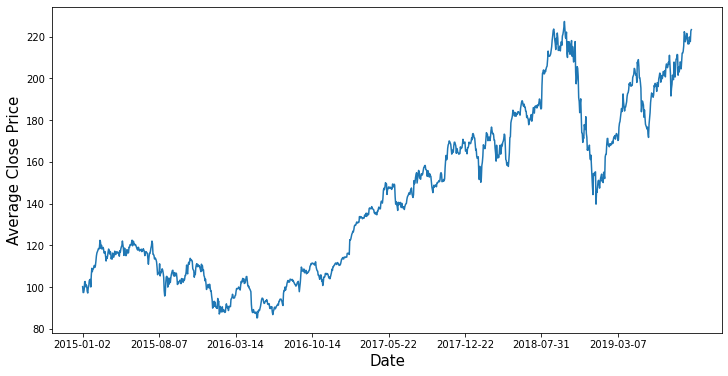

In [13]:
def plotStocks(data, dates, xticks, legend=False):
    plt.figure(figsize=(12,6))
    for datum in data:
        plt.plot(datum[0], datum[1], **datum[2])
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Average Close Price', fontsize=15)
    plt.xticks(np.arange(0, len(dates), xticks))
    plt.legend() if legend else None
    plt.show()

stock_data = [(df['date'], df['adj close'], {})]
plotStocks(stock_data, df['date'], 150)

### Create feature set and target vector

In [14]:
X = df.drop(labels=['adj close'], axis=1)
y = df['adj close']

print('Dimension of feature matrix:', X.shape)
print('Dimension of target vector:', y.shape)

Dimension of feature matrix: (1195, 4)
Dimension of target vector: (1195,)


### Create test and train datasets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

dates = X_test['date']

X_train = X_train.drop(labels=['date'], axis=1)
X_test = X_test.drop(labels=['date'], axis=1)

In [16]:
def addAvgClose(df, days=5):
    df['avg_close'] = 0.0

    for i, _ in df.iterrows():
        if i:
            df['avg_close'][i] = sum(df['adj close'][i - k] for k in range(1, i + 1 if i < (days + 1) else (days + 1))) / (i if i < (days + 1) else days)
            
def addVolatility(df):
    df['volatility'] = 0.0
    
    for i, _ in df.iterrows():
        if i > 1:
            df['volatility'][i] = df['adj close'][i - 1] / df['adj close'][i - 2]
    
def addSentiment(df, ticker):
    df['sentiment'] = 0.0
            
    sent_df = pd.read_csv('news_sentiments.csv')
    sent_df = sent_df.loc[sent_df['ticker'] == ticker]
    
    for i, _ in df.iterrows():
        s = df['date'][i]
        e = datetime.datetime.strptime(s, "%Y-%m-%d").date() - datetime.timedelta(days=7)
        sent = sent_df.query('release_date < "' + s + '" and release_date >= "' + e.strftime("%Y-%m-%d") + '"')
        df['sentiment'][i] = (sum(sent['sentiment']) / len(sent)) if len(sent) else 0.0

def addFeaturesAndPlotData(df, ticker):
    addAvgClose(df)
    addVolatility(df)
    addSentiment(df, ticker)
        
    stock_data = [(df['date'], df['adj close'], {})]
    plotStocks(stock_data, df['date'], 150)

def getTestAndTrain(df):
    X = df.drop(labels=['adj close'], axis=1)
    y = df['adj close']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    dates = X_test['date']

    X_train = X_train.drop(labels=['date'], axis=1)
    X_test = X_test.drop(labels=['date'], axis=1)
    
    return X_train, y_train, X_test, y_test, dates

def readData(ticker, cutoff='2019-10-01'):
    df = pd.read_csv('./data_clean/' + ticker + '.csv')
    df = df.sort_values('date')
    df = df.drop(['open','high','low','close','volume'], axis=1)

    if cutoff:
        df = df.query('date <= "' + cutoff + '"')
        df = df.reset_index(drop=True)
        
    return df

### Evaluate Model

In [17]:
def printGlobalStockRes(df, dates, y_pred):
    stock_data = [(df['date'], df['adj close'], {'color': 'green', 'label': 'Data'}),
                  (dates, y_pred, {'color': 'red', 'label': 'Predicted'})]
    plotStocks(stock_data, df['date'], 150, True)

def printLocalStockRes(dates, y_test, y_pred):
    stock_data = [(dates, y_test, {'color': 'green', 'label': 'Data'}),
                  (dates, y_pred, {'color': 'red', 'label': 'Predicted'})]
    plotStocks(stock_data, dates, 50, True)

def MSE(y_test, y_pred):
    err = mean_squared_error(y_test, y_pred)
    print('MSE:', err)

def MAE(y_test, y_pred):
    err = mean_absolute_error(y_test, y_pred)
    print('MAE:', err)

### Train Models

#### SVM regression

In [18]:
def SVMConfidence(svr, X_test, y_test):
    svm_confidence = svr.score(X_test, y_test)
    print('SVM Confidence:', svm_confidence)

def runSVMModelSelection():
    param_grid = {'kernel': ('linear','poly','rbf','sigmoid'),
                  'C': [1,5,10],
                  'degree': [3,8],
                  'coef0': [0.01,10,0.5],
                  'gamma': ('auto','scale')}
    svr = SVR()
    grids = GridSearchCV(svr, param_grid, cv=ShuffleSplit(test_size=0.20, n_splits=1), verbose=10)
    grids.fit(X_train, y_train)
    params_optimal = grids.best_params_

    svr = SVR(params_optimal)
    y_pred = svr.fit(X_train, y_train).predict(X_test)

def runSVM(ticker):
    print('SVM –', ticker)
    
    df = readData(ticker)
    addFeaturesAndPlotData(df, ticker)
    X_train, y_train, X_test, y_test, dates = getTestAndTrain(df)

    svr = SVR(kernel='linear')
    y_pred = svr.fit(X_train, y_train).predict(X_test)
    
    SVMConfidence(svr, X_test, y_test)
    
    printGlobalStockRes(df, dates, y_pred)
    printLocalStockRes(dates, y_test, y_pred)

#### Random Forests regression

In [19]:
def runRandomForest(ticker):
    print('Random Forest –', ticker)
    
    df = readData(ticker)
    addFeaturesAndPlotData(df, ticker)
    X_train, y_train, X_test, y_test, dates = getTestAndTrain(df)
    
    reg = RandomForestRegressor()
    y_pred = reg.fit(X_train, y_train).predict(X_test)
    
    printGlobalStockRes(df, dates, y_pred)
    printLocalStockRes(dates, y_test, y_pred)

SVM – AAPL


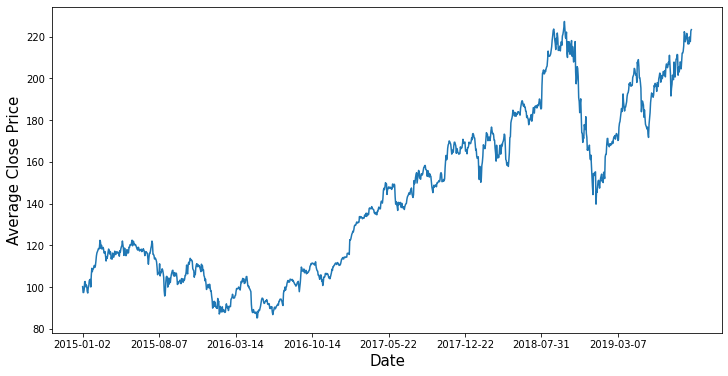

SVM Confidence: 0.9376565247536063


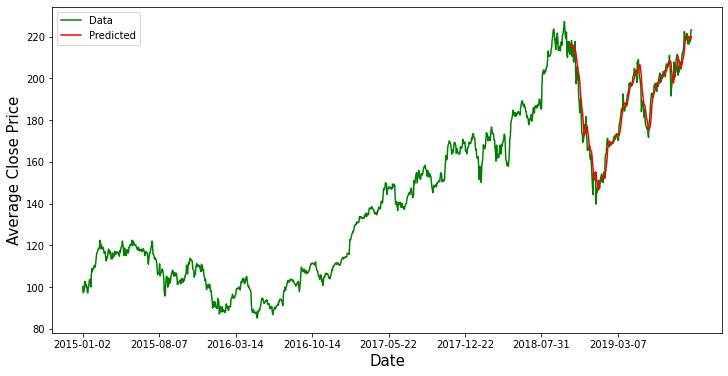

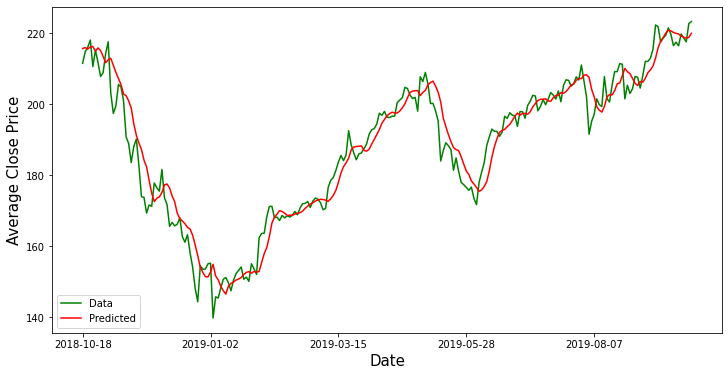

In [20]:
runSVM('AAPL')

Random Forest – AAPL


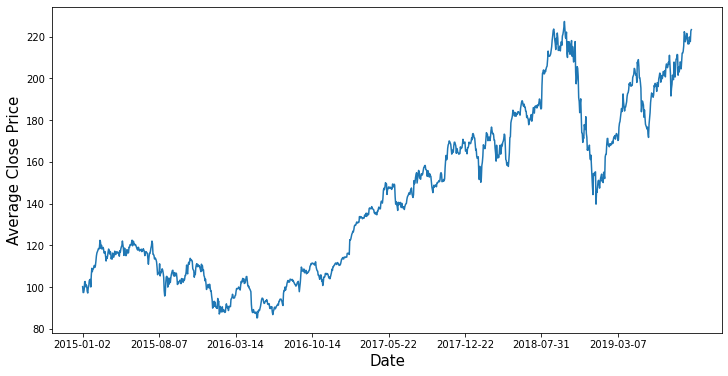

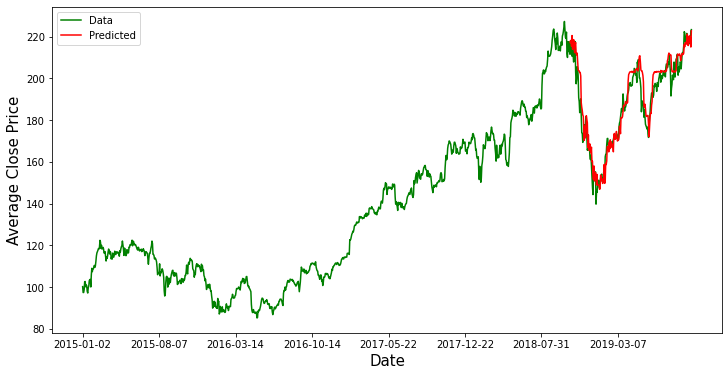

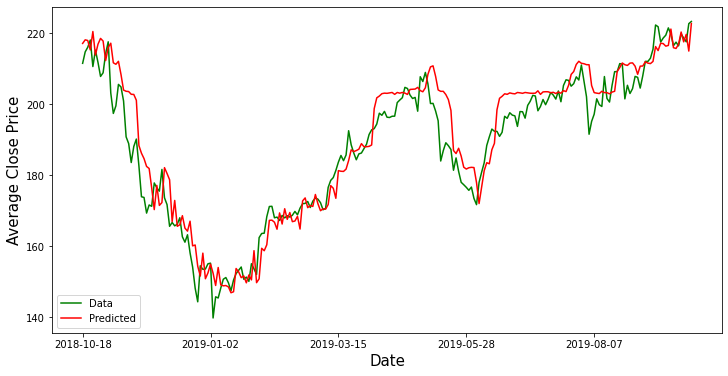

In [21]:
runRandomForest('AAPL')

SVM – TSLA


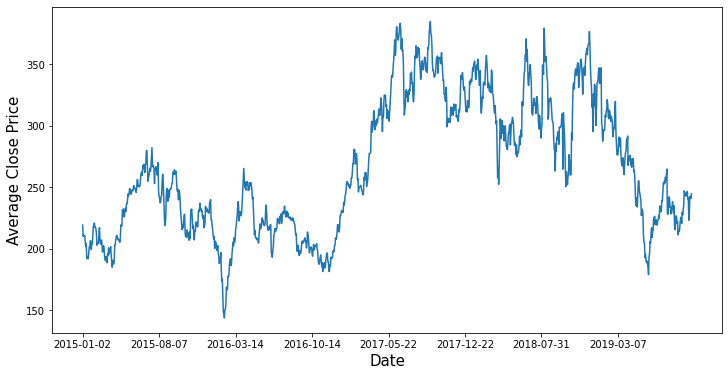

SVM Confidence: 0.9309483198795825


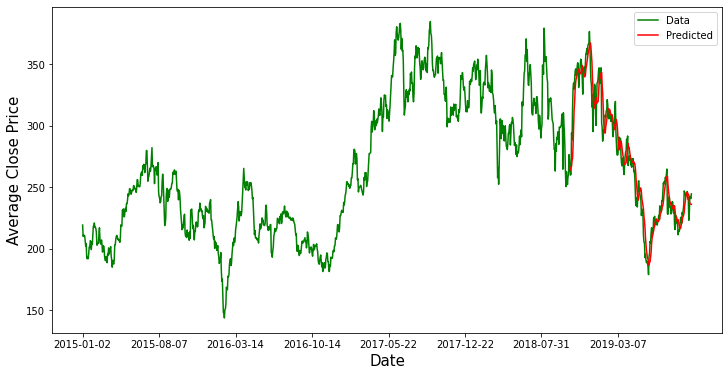

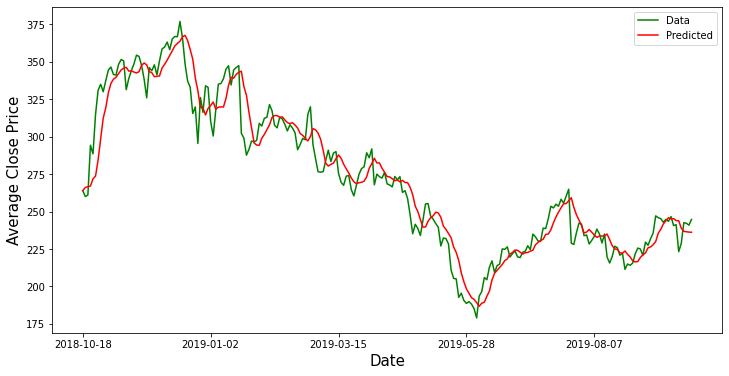

In [22]:
runSVM('TSLA')

Random Forest – TSLA


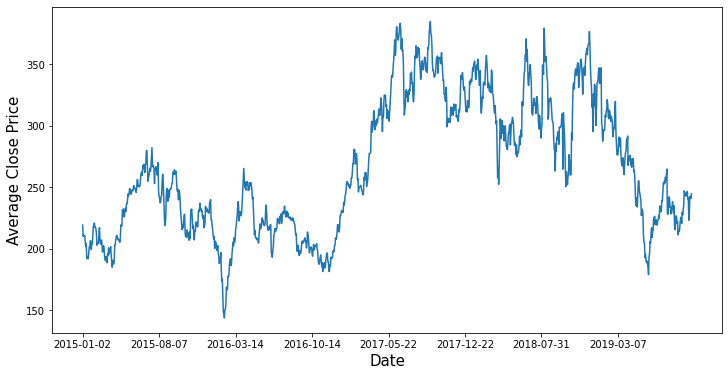

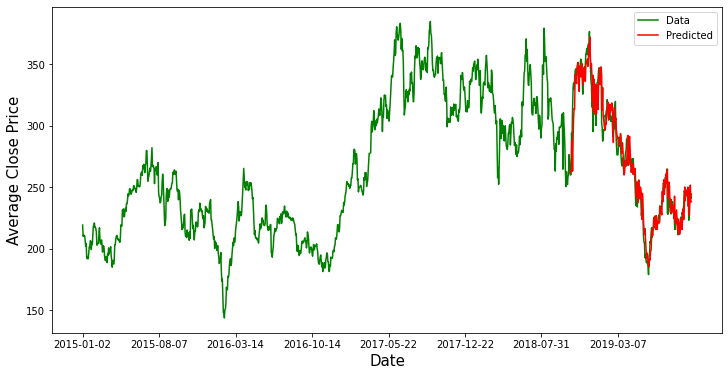

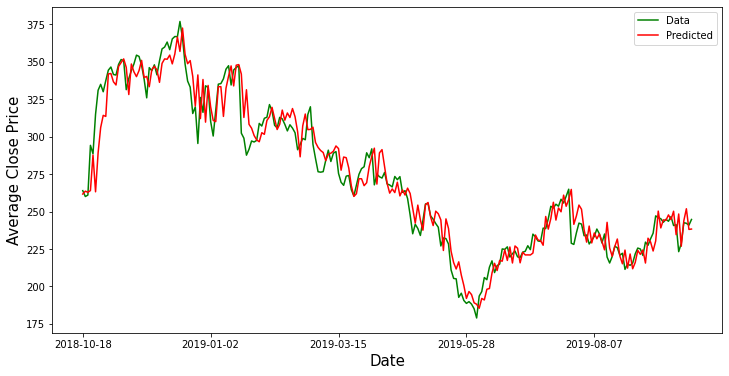

In [23]:
runRandomForest('TSLA')

SVM – JNJ


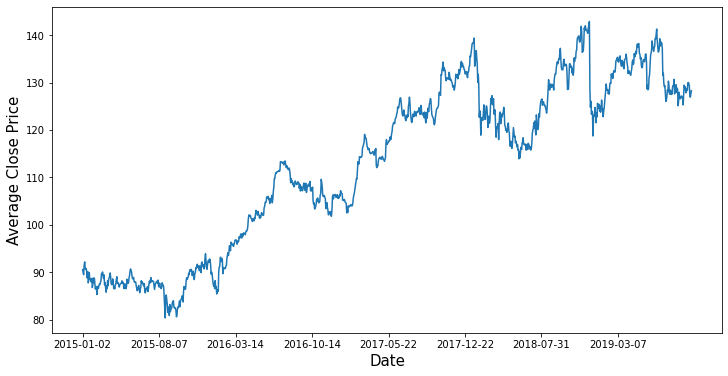

SVM Confidence: 0.77177194883934


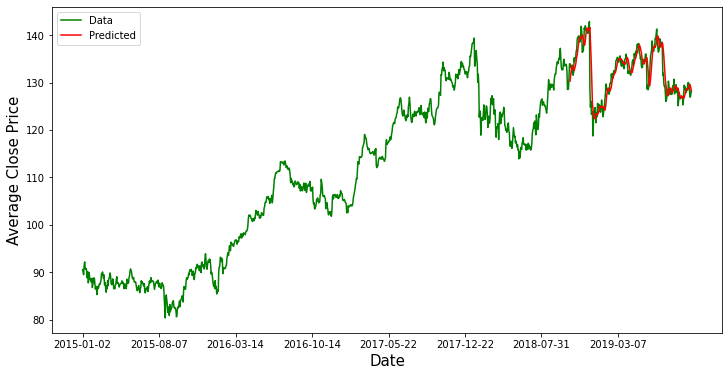

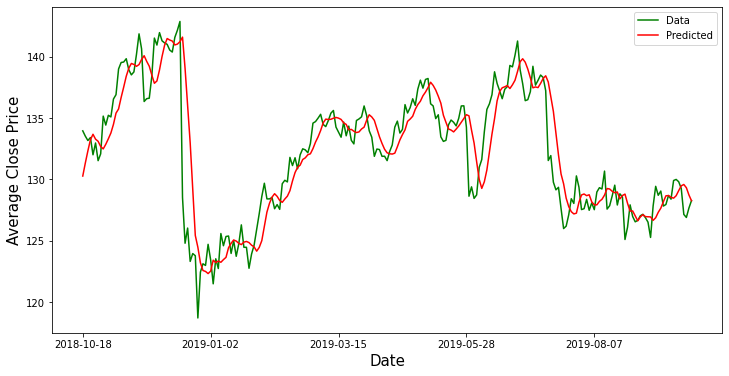

In [24]:
runSVM('JNJ')

Random Forest – JNJ


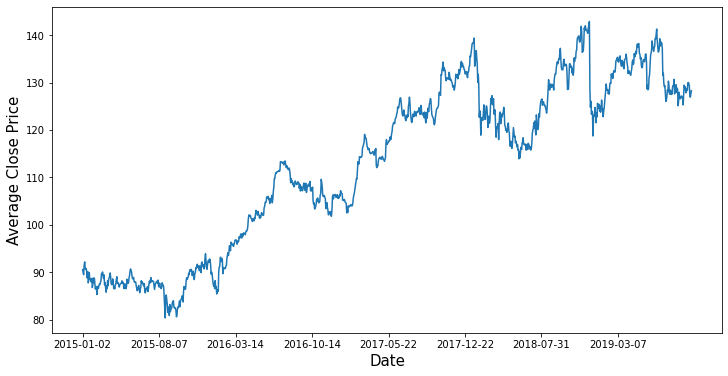

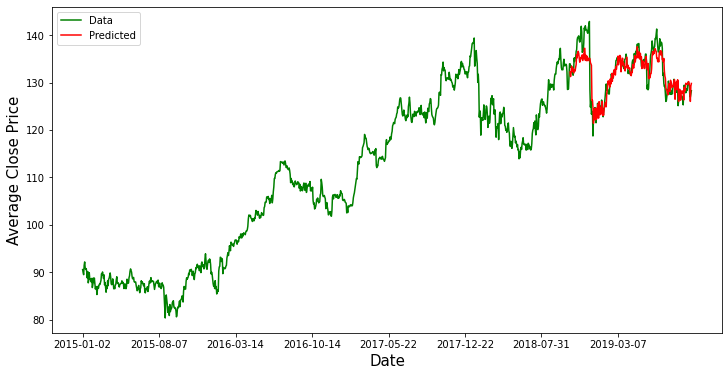

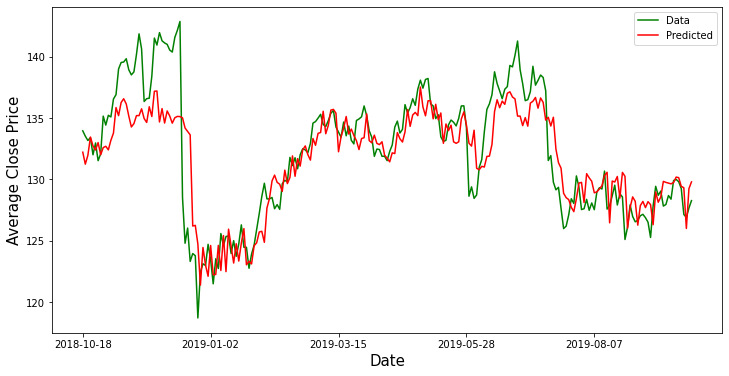

In [25]:
runRandomForest('JNJ')

In [26]:
# reg = RandomForestRegressor()

# n = len(X_test)
# to_pred = pd.DataFrame(data=[[0,0.0,0.0]], columns=['sentiment', 'avg_close'])
# y_pred = np.array([])

# data = X_train.copy(deep=True)
# prices = y_train.copy(deep=True).to_numpy()

# def prepNextInstance(to_pred, prices, l):
#     to_pred['sentiment'][0] = 1 if prices[l - 1] > prices[l - 2] else -1
#     to_pred['avg_close'][0] = prices[l - 1] / prices[l - 2]
#     to_pred['avg_close'][0] = sum(prices[i] for i in range(l - 5, l)) / 5

# for _ in range(n):
#     prepNextInstance(to_pred, prices, len(prices))
#     val = reg.fit(data, prices).predict(to_pred)
#     data = data.append(to_pred)
#     y_pred = np.append(y_pred, val)
#     prices = np.append(prices, val)

In [27]:
# stock_data = [(dates, y_test, {'color': 'green', 'label': 'Data'}),
#               (dates, y_pred, {'color': 'red', 'label': 'Predicted'})]
# plotStocks(stock_data, dates, 50, True)